**Tarea 1, Machine Learning and Data Analysis** \
Juan José Altamirano \
2022403951

## Importación de Librerías

In [154]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sklearn
import scipy 
from scipy.stats import nbinom
import seaborn as sns
from statsmodels.iolib.summary2 import summary_col
import missingno as msn
import datetime as dt

## Lectura de datos, exploración y limpieza de datos

1. Cargar la base de datos en el ambiente. Identifique los tipos de datos que se encuentran en la base, realice estadisticas descriptivas sobre las variables importantes (Hint: Revisar la distribuciones, datos faltantes, outliers, etc.) y limpie las variables cuando sea necesario. 

In [155]:
df= pd.read_csv('machine_failure_data.csv', delimiter=",")


Las variables iniciales de estudio son las siguientes:

- Date: data medida en frecuencia diaria
- Location: ubicacion del medidor
- Min_Temp: temperatura minima observada
- Max_Temp: temperatura maxima observada
- Leakage: Filtracion medida en el area
- Evaporation: Tasa de evaporacion
- Electricity: Consumo electrico KW
- Parameter#: Diferentes sensores de reportando direccion y velocidad de viento en distintos momentos del dia, asi como otras metricas relevantes.
- Failure today: El sensor reporta fallo (o no)

La variable "Failure_today" se transforma de manera binaria, indicando con un 1 si el sensor reporta un fallo, 0 en otro caso.

In [156]:
df['Failure_today']=df['Failure_today'].apply(lambda x: 0 if x=='No' else 1)

A continuación se muestran visualmente los datos vacíos en el dataframe en cada una de las variables:

<AxesSubplot: >

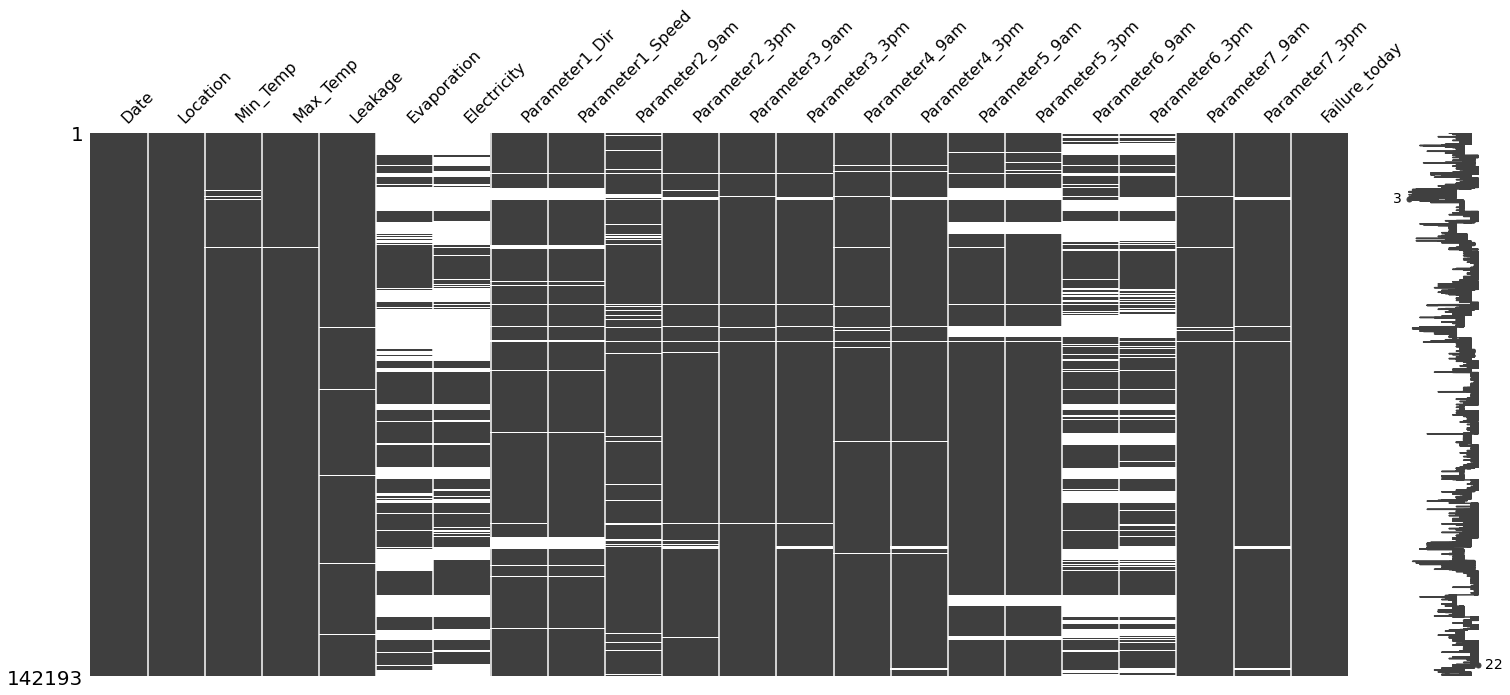

In [157]:
msn.matrix(df)

Notamos que las variables Evaporation, Electricity y el parámetro 6 (AM y PM) muestran un alto porcentaje de missing data, por lo que serán excluidos del análisis.

In [158]:
borrar= ['Parameter6_9am','Parameter6_3pm','Evaporation','Electricity',]
df.drop(borrar,axis=1, inplace=True)
df.reset_index(inplace=True, drop=True)


In [159]:
df2=df.copy()

Para mejor manejo de las direcciones, disminuiremos la cantidad, pasando de 16 posibles direcciones a 8, siguiendo la transformación del diccionario definido en la siguiente celda:

In [160]:
map_dir= {'SSE':'SE','WSW':'SW','SSW':'S','WNW':'W','ENE':'NE','ESE':'E','NNW':'NW','NNE':'N'}
cols_dir = ['Parameter1_Dir','Parameter2_9am', 'Parameter2_3pm']
df2[cols_dir] = df2[cols_dir].replace(map_dir)
df2['Parameter1_Dir'].value_counts()

SE    18302
W     17846
SW    17698
S     17559
E     16376
N     15466
NE    15052
NW    14564
Name: Parameter1_Dir, dtype: int64

Transformamos la columna date para incorporar nuevas columnas de "Año" y "Mes" con el objetivo de facilitar el manejo temporal a posteriori.

In [161]:
df2['Date'] = pd.to_datetime(df2['Date'])
df2['Mes'] = df2['Date'].dt.month_name(locale='es')
df2['Año'] = df2['Date'].dt.year

<AxesSubplot: xlabel='Año', ylabel='count'>

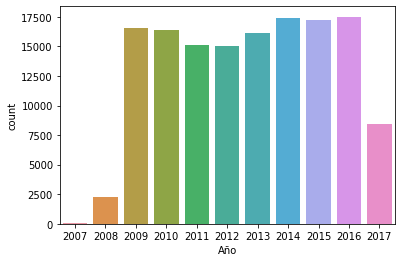

In [162]:
sns.countplot(x='Año',data=df2)

Notamos la poca cantidad de datos para los años 2007, 2008 y 2017, por lo que serán excluídos del análisis.

In [163]:
mask1 = df2[(df2['Año']==2007)|
           (df2['Año']==2008)|
           (df2['Año']==2017)]
df2.drop(mask1.index,inplace=True)
df2.reset_index(inplace=True, drop=True)

Por último, la variable Leakage está directamente relacionada a la variable "Failure_Today", ya que si no hay filtraciones, no se reportan fallos y si hay filtraciones, se reportan fallos. Por lo tanto, se considera como una variable que sobreexplica el modelo, así que se excluirá del análisis.

<AxesSubplot: xlabel='Failure_today', ylabel='Leakage'>

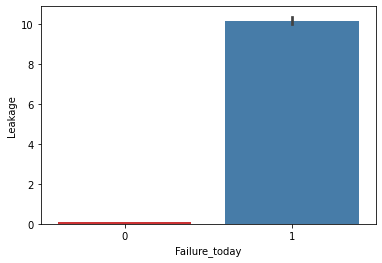

In [164]:
sns.barplot(data=df2, y='Leakage', x='Failure_today', palette='Set1')

In [165]:
df2.drop("Leakage",axis=1, inplace=True)
df2.reset_index(inplace=True, drop=True)

<AxesSubplot: >

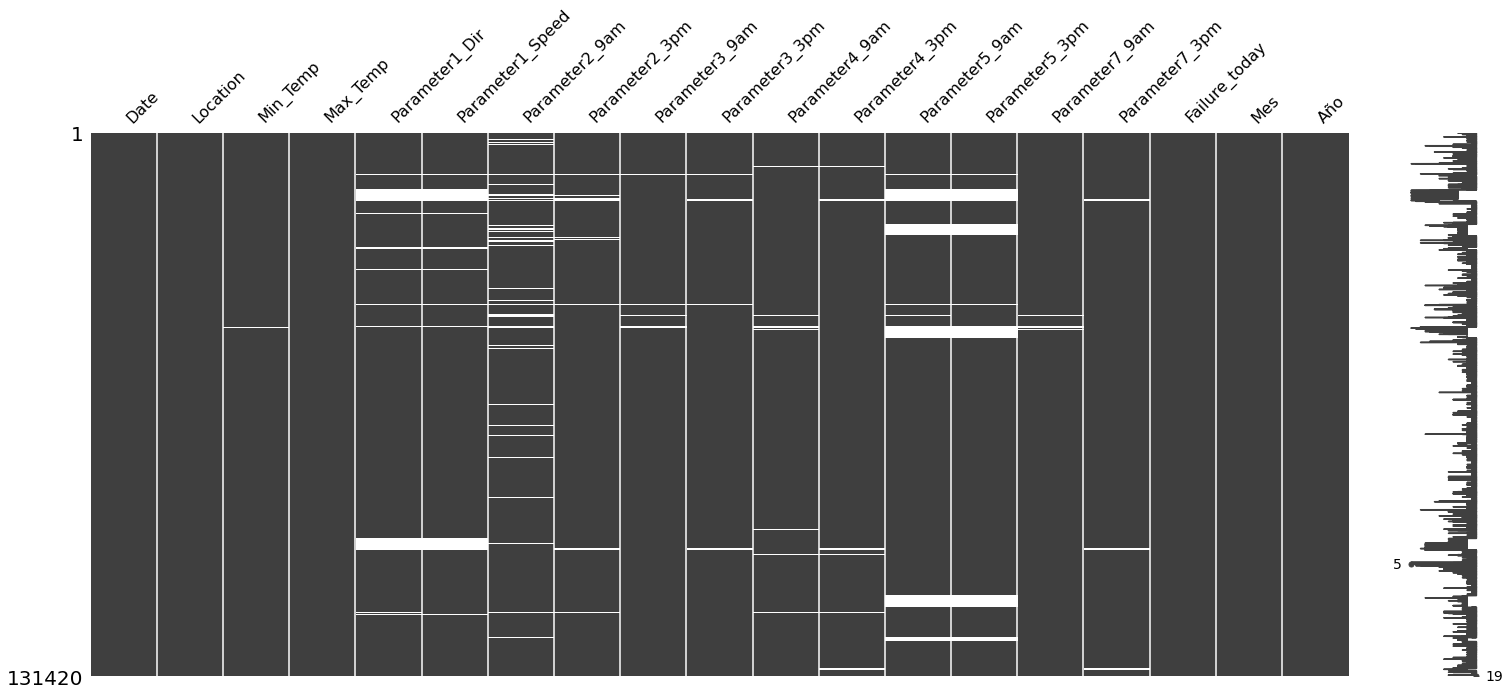

In [166]:
msn.matrix(df2)

A continuación, se excluirán del análisis todas las observaciones que cuenten con algun dato vacío.

In [167]:
df2.dropna(inplace=True)
df2.reset_index(inplace=True, drop=True)

El siguiente gráfico radial muestra en qué dirección del viento del parámetro 1 se muestra la mayor cantidad de fallas:

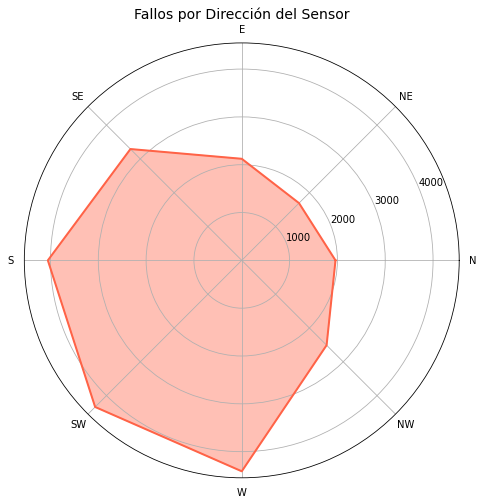

In [168]:

# Direcciones ordenadas en sentido horario
directions = ['N',
              #'NNE',
              'NE',
              #'ENE',
              'E',
              #'ESE',
              'SE',
              #'SSE',
              'S',
              #'SSW',
              'SW',
              #'WSW',
              'W',
              #'WNW',
              'NW',
              #'NNW'
              ]

# Filtrar datos con fallo
failures = df2[df2['Failure_today'] == 1]

# Contar ocurrencias por dirección
counts = failures['Parameter1_Dir'].value_counts()
counts = counts.reindex(directions, fill_value=0)

# Convertir a radianes para el gráfico
angles = np.deg2rad(np.linspace(0, 360, len(directions), endpoint=False))

# Repetir el primer valor al final para cerrar el círculo
values = counts.values.tolist()
values += values[:1]
angles = np.append(angles, angles[0])

# Graficar
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)
ax.plot(angles, values, linewidth=2, linestyle='solid', color='tomato')
ax.fill(angles, values, alpha=0.4, color='tomato')
ax.set_xticks(np.deg2rad(np.linspace(0, 360, len(directions), endpoint=False)))
ax.set_xticklabels(directions)
ax.set_title('Fallos por Dirección del Sensor', size=14)
plt.show()


In [169]:
df2

,Date,Location,Min_Temp,Max_Temp,Parameter1_Dir,Parameter1_Speed,Parameter2_9am,Parameter2_3pm,Parameter3_9am,Parameter3_3pm,Parameter4_9am,Parameter4_3pm,Parameter5_9am,Parameter5_3pm,Parameter7_9am,Parameter7_3pm,Failure_today,Mes,Año
0,2009-01-01,3,11.30,26.50,W,56.00,W,W,19.00,31.00,46.00,26.00,1004.50,1003.20,19.70,25.70,0,Enero,2009
1,2009-01-02,3,9.60,23.90,W,41.00,SW,S,19.00,11.00,44.00,22.00,1014.40,1013.10,14.90,22.10,0,Enero,2009
2,2009-01-03,3,10.50,28.80,SE,26.00,SE,E,11.00,7.00,43.00,22.00,1018.70,1014.80,17.10,26.50,0,Enero,2009
3,2009-01-04,3,12.30,34.60,W,37.00,SE,NW,6.00,17.00,41.00,12.00,1015.10,1010.30,20.70,33.90,0,Enero,2009
4,2009-01-05,3,12.90,35.80,W,41.00,NE,NW,6.00,26.00,41.00,9.00,1012.60,1009.20,22.40,34.40,0,Enero,2009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105378,2016-12-27,42,22.10,35.80,W,43.00,W,W,17.00,31.00,77.00,41.00,997.80,995.20,26.00,33.50,1,Diciembre,2016
105379,2016-12-28,42,22.60,36.80,NW,50.00,NW,W,30.00,15.00,63.00,39.00,1000.00,998.80,29.70,34.00,0,Diciembre,2016
105380,2016-12-29,42,23.20,38.00,S,33.00,S,SW,17.00,17.00,25.00,14.00,1004.40,1001.00,28.70,36.40,0,Diciembre,2016
105381,2016-12-30,42,19.70,37.00,E,37.00,E,W,22.00,6.00,30.00,23.00,1004.60,1000.90,28.20,35.10,0,Diciembre,2016


El siguiente gráfico de correlación nos permite ver qué variables están altamente correlacionadas con el fin de evaluar su exclusión del modelo.

<AxesSubplot: >

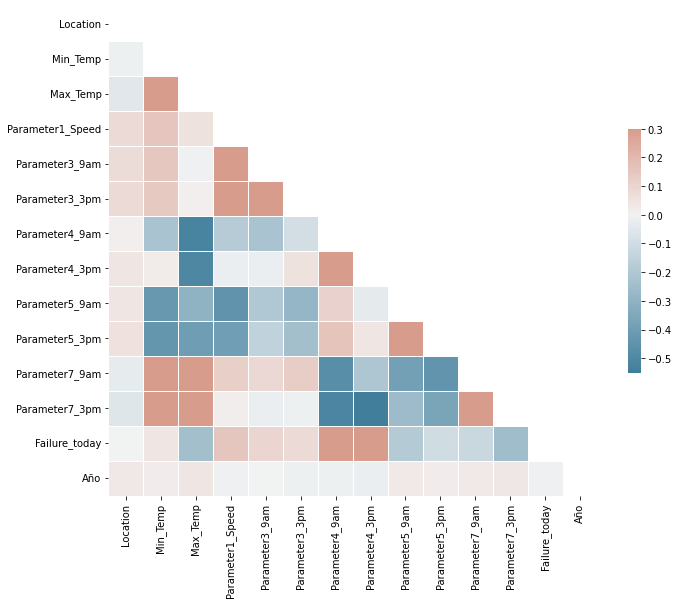

In [171]:
corr = df2.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

No existe ningun par de variables con una correlación significativa (cercana a 1), por lo que todas las variables presentes se incorporarán al análisis.

Con el fin de detectar supuestas variaciones estacionales, se crea la variable estación, la cual según el mes del año, se le asignará la estación a la que corresponde. Asumimos que los datos son originarios del hemisferio sur y agruparemos la estación Primavera y Otoño en la categoría "Otro", para detectar cambios más significativos. 

In [172]:
def get_estacion(mes):
    if mes in ['Diciembre', 'Enero', 'Febrero']:
        return 'Invierno'
    elif mes in ['Junio', 'Julio', 'Agosto']:
        return 'Verano'
    else:
        return 'Otro'

df2['Estacion'] = df2['Mes'].apply(get_estacion)

Establecemos el orden simbólico de las estaciones con el objetivo de que en nuestros modelos se tome como referencia la estación "Otro"

In [173]:
orden_estaciones = ['Otro', 'Verano', 'Invierno']
df2['Estacion'] = pd.Categorical(df2['Estacion'], categories=orden_estaciones, ordered=True)

## Modelo OLS

2. Ejecute un modelo de probabilidad lineal (*MCO*) que permita explicar la probabilidad de que un dia se reporte fallo medido por sensor, a partir de las informacion disponible. Seleccione las variables dependientes a incluir en el modelo final e interprete su significado. 

**R:** \
En base a la formulación del modelo, se toma como referencia los siguientes valores de las variables categóricas:
- Estación: Otro
- Año: 2009
- Location: 2
- Parameter1_Dir: East
- Parameter2_9am: East
- Parameter2_3pm: East

Los principales efectos sobre la base establecida son la relación negativa de pasar a invierno o a verano. Esto significa que en comparación a la estación "Otro", en Invierno y en Verano tienden a disminuir la probabilidad de que el sensor 2 detecte un fallo.

Al variar entre años, notamos una tendencia al aumento de probabilidad de que el sensor detecte un fallo, sin embargo, el cambio a algunos años como 2011 y 2016 no son significativos.

Si consideramos el cambio a otro sensor, notamos variabilidades en ambos sentidos, pero predominantemente negativas, lo que permite intuir que el sensor base (2) pudo haber detectado mayor cantidad de fallas en comparación a la gran cantidad de sensores que se relaciona de manera negativa en los coeficientes de la regresión.

Respecto a los parámetros direccionales, podemos concluir que una variación en el parámetro 1 no es significativa para el incremento o disminución del valor de nuestra variable explicativa.
El parámetro 2 presenta coeficientes significativos y en su mayoría positivos, por lo que un cambio en las direcciones base (Este), tiende a aumentar la probabilidad de que el sensor detecte un fallo.

Por último, se destaca que a medida que aumenta la temperatura máxima detectada, también disminuye la probabilidad de tener fallas y análogamente, lo cual es un resultado que llama la atención por que en cierta parte desafía la lógica.

Dichos resultados se pueden deber a que un modelo de mínimos cuadrados no es lo suficientemente adecuado para estimar un valor binario, por lo que se continúa estudiando los datos con otros modelos.

In [174]:
resultado = smf.ols('Failure_today ~ C(Estacion) + C(Año) + C(Location) + Min_Temp + Max_Temp + C(Parameter1_Dir) + Parameter1_Speed + C(Parameter2_9am) + C(Parameter2_3pm) + Parameter3_9am + Parameter3_3pm + Parameter4_9am + Parameter4_3pm + Parameter5_9am + Parameter5_3pm + Parameter7_9am + Parameter7_3pm' , data=df2).fit() 
print(resultado.summary())

                            OLS Regression Results                            
Dep. Variable:          Failure_today   R-squared:                       0.298
Model:                            OLS   Adj. R-squared:                  0.297
Method:                 Least Squares   F-statistic:                     531.0
Date:               jue, 24 abr. 2025   Prob (F-statistic):               0.00
Time:                        23:52:45   Log-Likelihood:                -39926.
No. Observations:              105383   AIC:                         8.002e+04
Df Residuals:                  105298   BIC:                         8.084e+04
Df Model:                          84                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

## *Modelo Probit*

3. Ejecute un modelo *probit* para responder a la pregunta 2. Seleccione las variables dependientes a incluir en el modelo final e interprete su significado. 

**R:** Si bien los resultados en coeficientes son similares entre el modelo OLS y los efectos marginales del modelo Probit, podemos notar que existen diferencias en la significancia de ciertos coeficientes como el cambio a la estación de Invierno, que el modelo Probit ya no lo considera significativo.

Además, Probit arroja que el cambio a cualquier año distinto al base también es significativo, pero mantiene la relación positiva en torno a la estimación de nuestra variable Failure Today.

Por otro lado, disminuye la magnitud de gran parte de los coeficientes, suavizando en cierta forma el impacto de algunas variables sobre la variable failure_today.

In [175]:

probit = smf.probit('Failure_today ~ C(Estacion) + C(Año) + C(Location) + Min_Temp + Max_Temp + C(Parameter1_Dir) + Parameter1_Speed + C(Parameter2_9am) + C(Parameter2_3pm) + Parameter3_9am + Parameter3_3pm + Parameter4_9am + Parameter4_3pm + Parameter5_9am + Parameter5_3pm + Parameter7_9am + Parameter7_3pm' , data=df2).fit() 
print(probit.summary())

mfx = probit.get_margeff()
print(mfx.summary())

Optimization terminated successfully.
         Current function value: 0.363349
         Iterations 7
                          Probit Regression Results                           
Dep. Variable:          Failure_today   No. Observations:               105383
Model:                         Probit   Df Residuals:                   105298
Method:                           MLE   Df Model:                           84
Date:               jue, 24 abr. 2025   Pseudo R-squ.:                  0.3282
Time:                        23:52:53   Log-Likelihood:                -38291.
converged:                       True   LL-Null:                       -57001.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  27.6812      1.036     26.722      0.000      25.651   

## *Logit*

4. Ejecute un modelo *logit*  para responder a la pregunta 2. Seleccione las variables dependientes a incluir en el modelo final e interprete su significado. 

Se mantiene el uso de las mismas variables explicativas.

Notamos que el cambio desde la estación base a la estación Invierno continua siendo no significativo.

Además, se mantiene el resultado de la no significancia de los coeficientes asociados a las direcciones del parámetro 1, lo que puede presumir una baja explicación de la variabilidad de Failure today en torno a esta variable.

El modelo Logit vuelve a reafirmar que si la temperatura máxima detectada por el sensor aumenta, tienden a detectarse menos fallas, y si la temperatura mínima aumenta en una unidad, la probabilidad de fallo aumenta en un 1.4%. Curioso...

In [176]:
logit = smf.logit('Failure_today ~ C(Estacion) + C(Año) + C(Location) + Min_Temp + Max_Temp + C(Parameter1_Dir) + Parameter1_Speed + C(Parameter2_9am) + C(Parameter2_3pm) + Parameter3_9am + Parameter3_3pm + Parameter4_9am + Parameter4_3pm + Parameter5_9am + Parameter5_3pm + Parameter7_9am + Parameter7_3pm' , data=df2).fit()
print(logit.summary())
mfx = logit.get_margeff()
print(mfx.summary())

Optimization terminated successfully.
         Current function value: 0.361726
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:          Failure_today   No. Observations:               105383
Model:                          Logit   Df Residuals:                   105298
Method:                           MLE   Df Model:                           84
Date:               jue, 24 abr. 2025   Pseudo R-squ.:                  0.3312
Time:                        23:54:13   Log-Likelihood:                -38120.
converged:                       True   LL-Null:                       -57001.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  47.8709      1.828     26.192      0.000      44.289   

5. Comente los resultados obtenidos en 2, 3 y 4. ¿Cuáles y por qué existen las diferencias entre los resultados?. En su opinión, ¿Cuál sería el más adecuado para responder la pregunta de investgación y por qué? ¿Qué variables resultaron ser robustas a la especificación?

**R:** Las principales diferencias se encuentran en la significancia de ciertas variables en algunos modelos y además de la magnitud de los coeficientes. Estas diferencias se originan por la forma de resolución que hay tras cada modelo. Consideremos que OLS busca predecir una variable continua y en este caso forzamos a predecir una variable binaria, lo que puede resultar en interpretaciones erróneas.

Probit y Logit si nos permite operar con una estimación de una variable binaria, además permite estudiar la no linealidad del modelo. Además restringe el valor de porbabilidad obtenido entre [0,1]. Considerando la similitud de los resultados, se recomendaría cualquiera de los dos para poder la pregunta de investigación.

En estos 3 modelos, las principales variables significativas fueron, Max Temp, Min Temp y el cambio estacional a Verano, que fueron consistentes con la significancia y el impacto en la estimación de la variable.

## *Agrupación por mes* 

In [177]:
df_mes=df2.copy()

Creamos una variable que junte el mes y el año para facilitar el estudio de los datos

In [178]:
df_mes['MesYear']= df_mes['Mes'] + " " + df_mes['Año'].astype(str)

Agrupamos por Mes/Año y Location (sensor), de esta forma tendremos el promedio de los parámetros de cada sensor, en cada mes y en cada año, además de la sunma de todas las fallas detectadas por cada sensor en cada mes y en cada año.

Para continuar con el estudio de la variación estacional, se mantiene la variable estación.

In [179]:
df_mes=df_mes.groupby(['MesYear','Location']).agg({'Min_Temp': 'mean',
                            'Max_Temp': 'mean',
                            'Parameter1_Speed': 'mean',
                            'Parameter3_9am': 'mean',
                            'Parameter3_3pm': 'mean',
                            'Parameter4_9am': 'mean',
                            'Parameter4_3pm': 'mean',
                            'Parameter5_9am': 'mean',
                            'Parameter5_3pm': 'mean',
                            'Parameter7_9am': 'mean',
                            'Parameter7_3pm': 'mean',
                            'Estacion':'first',
                            'Failure_today': 'sum',
                            }).reset_index()

In [180]:
df_mes

,MesYear,Location,Min_Temp,Max_Temp,Parameter1_Speed,Parameter3_9am,Parameter3_3pm,Parameter4_9am,Parameter4_3pm,Parameter5_9am,Parameter5_3pm,Parameter7_9am,Parameter7_3pm,Estacion,Failure_today
0,Abril 2009,1,13.21,22.79,35.86,10.04,16.50,57.82,45.86,1019.62,1017.43,17.61,21.36,Otro,6
1,Abril 2009,3,9.09,20.84,37.38,9.76,14.05,67.62,44.19,1019.12,1016.09,13.90,19.96,Otro,6
2,Abril 2009,4,13.73,28.67,38.96,15.72,18.28,30.48,16.92,1018.35,1014.53,20.83,27.87,Otro,0
3,Abril 2009,5,12.35,22.23,35.07,12.44,16.78,75.96,57.67,1019.46,1017.17,17.43,20.95,Otro,9
4,Abril 2009,6,6.56,18.02,44.11,19.43,20.89,78.64,52.93,1018.72,1016.76,11.67,16.67,Otro,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3821,Septiembre 2016,45,8.69,16.63,34.19,10.50,12.92,82.65,62.85,1015.36,1013.15,11.90,15.31,Otro,10
3822,Septiembre 2016,46,10.25,21.39,49.92,21.62,26.15,67.15,54.38,1016.32,1013.29,16.10,20.02,Otro,4
3823,Septiembre 2016,47,7.49,15.63,45.04,16.04,20.07,71.64,65.86,1019.45,1017.58,12.39,13.80,Otro,16
3824,Septiembre 2016,48,12.99,19.44,43.23,18.10,18.03,62.13,61.73,1014.82,1012.27,16.68,18.12,Otro,4


6. Agregue la data a nivel mensual, usando la data promedio de las variables (ignorando aquellas categoricas, como la direccion del viento). En particular, genere una variable que cuente la cantidad de fallos observados en un mes, utilice un valor de 0 si en ese mes no se reporto fallos en ningun dia. Use un modelo Poisson para explicar el numero de fallas por mes. Seleccione las variables dependientes a incluir en el modelo final e interprete su significado. 

In [181]:
poisson=smf.glm('Failure_today ~ C(Estacion) + C(Location) + Min_Temp + Max_Temp + Parameter1_Speed + Parameter3_9am + Parameter3_3pm + Parameter4_9am + Parameter4_3pm + Parameter5_9am + Parameter5_3pm + Parameter7_9am + Parameter7_3pm' , data=df_mes,family=sm.families.Poisson()).fit()
print(poisson.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:          Failure_today   No. Observations:                 3826
Model:                            GLM   Df Residuals:                     3769
Model Family:                 Poisson   Df Model:                           56
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8489.8
Date:               jue, 24 abr. 2025   Deviance:                       4055.0
Time:                        23:54:51   Pearson chi2:                 3.64e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.8599
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

Calculamos los odds ratios para medir la variación porcentual que aporta cada coeficiente:

In [182]:
pd.set_option('display.float_format', '{:.2f}'.format)
coef=poisson.params
odds_ratios = np.exp(coef)
odds_ratios = 100*(odds_ratios-1)
odds_ratios

Intercept                 97441192603.56
C(Estacion)[T.Verano]             -13.86
C(Estacion)[T.Invierno]            -9.37
C(Location)[T.3]                  -15.98
C(Location)[T.4]                   12.36
C(Location)[T.5]                  -25.64
C(Location)[T.6]                  -40.09
C(Location)[T.7]                  -23.44
C(Location)[T.8]                   -3.36
C(Location)[T.9]                    3.20
C(Location)[T.10]                 -18.00
C(Location)[T.11]                  -3.60
C(Location)[T.12]                   0.62
C(Location)[T.13]                 -41.55
C(Location)[T.14]                 -25.01
C(Location)[T.15]                  -5.65
C(Location)[T.16]                 -48.37
C(Location)[T.17]                 -39.42
C(Location)[T.18]                 -41.76
C(Location)[T.19]                  -9.53
C(Location)[T.20]                 -28.83
C(Location)[T.21]                 -14.48
C(Location)[T.22]                   2.26
C(Location)[T.23]                 -11.14
C(Location)[T.26

<AxesSubplot: xlabel='plambda', ylabel='Count'>

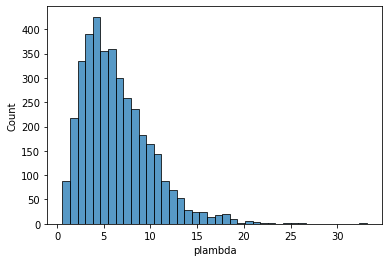

In [183]:
df_mes['plambda'] = poisson.mu
sns.histplot(data=df_mes, x="plambda",bins=40)

**R:** Para construir la distribución Poisson, consideramos solo variables continuas, además de incorporar las variables categóricas de Location y Estacion, para poder analizar el cambio en torno a las categorías base.

Interprentando los coeficientes más significativos, podemos notar que al cambiar de la estación Otros a Verano o Invierno, hay una disminución del 13.7% y un 9.94% respectivamente en la tasa esperada de fallas para las categorías bases.

Además, al aumentar en una unidad la temperatura mínima, se espera un incremento de 5.26% en la tasa esperada de fallas.

Se destaca que la variación de la temperatura máxima detectada, no se considera significativa para estimar una variación en la tasa esperada.

Notamos que la mayor cantidad de errores estimados por sensor se encuentra entre 4 y 7, y el gráfico de ocurrencias sigue gráficamente una distribución Poisson. Lo que podría indicar que no existe una sobre dispersión.



7. Determine sobre dispersion en la data y posible valor optimo de alpha para un modelo Binomial Negativa.


Los resultados del test de dispersión nos arrojan que el parámetro de la regresión auxiliar es significativo, lo que puede demostrar cierto nivel de sobredispersión, es decir, el modelo de Poisson podría no capturar toda la varianza, por lo que convendría usar Binomial Negativa.

In [184]:
aux=((df_mes['Failure_today']-poisson.mu)**2-poisson.mu)/poisson.mu
auxr=sm.OLS(aux,poisson.mu).fit()
print(auxr.summary())

                                 OLS Regression Results                                
Dep. Variable:          Failure_today   R-squared (uncentered):                   0.001
Model:                            OLS   Adj. R-squared (uncentered):              0.001
Method:                 Least Squares   F-statistic:                              4.148
Date:               jue, 24 abr. 2025   Prob (F-statistic):                      0.0418
Time:                        23:54:52   Log-Likelihood:                         -6700.8
No. Observations:                3826   AIC:                                  1.340e+04
Df Residuals:                    3825   BIC:                                  1.341e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Para binomial negativa, utilizamos la exponencial del coeficiente obtenido en la regresión auxiliar para poder estimar el valor de alpha:

In [185]:
a=np.exp(-0.0068)

8. Usando la informacion anterior, ejecute un modelo Binomial Negativa para responder a la pregunta 6. Seleccione las variables dependientes a incluir en el modelo final e interprete su significado. 

**R:** A modo general , el sensor (location) y la estación del año son factores relevantes y explican bastante de la variación del número de fallas.

Se continúa con el resultado de a mayor mínima, más fallas; a mayor máxima, menos, pero con magnitudes distintas a Poisson, sin embargo, BN detecta que ninguna de estas dos variables es significativas.

Notamos como el parámetro 7 tiene una variación positiva si aumenta en una unidad por la mañana y un efecto completamente contrario si aumenta en una unidad por la tarde. (17% y -16% aproximadamente).

Por último, la mayoría de los sensores tiene efectos negativos (menor riesgo de falla respecto a la ubicación de referencia). Los sensores más relevantes son:

- 44: -54.44%

- 48: -57.26%


In [186]:
negbin=smf.glm('Failure_today ~ C(Estacion) + C(Location) + Min_Temp + Max_Temp + Parameter1_Speed + Parameter3_9am + Parameter3_3pm + Parameter4_9am + Parameter4_3pm + Parameter5_9am + Parameter5_3pm + Parameter7_9am + Parameter7_3pm',
               data=df_mes,
               family=sm.families.NegativeBinomial(alpha=a)).fit()
print(negbin.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:          Failure_today   No. Observations:                 3826
Model:                            GLM   Df Residuals:                     3769
Model Family:        NegativeBinomial   Df Model:                           56
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -10596.
Date:               jue, 24 abr. 2025   Deviance:                       937.88
Time:                        23:54:52   Pearson chi2:                     686.
No. Iterations:                     9   Pseudo R-squ. (CS):             0.2673
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

Obtenemos los odds ratios para medir las variaciones porcentuales:

In [187]:
coef=negbin.params
odds_ratios = np.exp(coef)
odds_ratios = 100*(odds_ratios-1)
odds_ratios

Intercept                 232559407886.95
C(Estacion)[T.Verano]              -15.43
C(Estacion)[T.Invierno]            -12.48
C(Location)[T.3]                    -8.62
C(Location)[T.4]                     4.71
C(Location)[T.5]                   -33.96
C(Location)[T.6]                   -41.86
C(Location)[T.7]                   -19.42
C(Location)[T.8]                   -18.32
C(Location)[T.9]                   -16.67
C(Location)[T.10]                  -15.37
C(Location)[T.11]                    0.40
C(Location)[T.12]                  -11.36
C(Location)[T.13]                  -45.49
C(Location)[T.14]                  -51.20
C(Location)[T.15]                  -16.89
C(Location)[T.16]                  -49.06
C(Location)[T.17]                  -61.35
C(Location)[T.18]                  -43.49
C(Location)[T.19]                   -5.40
C(Location)[T.20]                  -27.33
C(Location)[T.21]                   -5.56
C(Location)[T.22]                    0.79
C(Location)[T.23]                 


9. Comente los resultados obtenidos en 6, 7 y 8. ¿Cuáles y por qué existen las diferencias entre los resultados?. En su opinión, ¿Cuál sería el más adecuado para responder la pregunta de investgación y por qué? ¿Qué variables resultaron ser robustas a la especificación?

 En primer lugar, en los cambios estacionales los efectos(odds ratios) entre Poisson BN son relativamente similares, aunque en Poisson son levemente menos negativos, lo cual puede indicar que el modelo Poisson subestima un poco la reducción de fallas en algunas estaciones.

 En torno al cambio de un sensor a otro, el modelo Poisson tiende a exagerar efectos (más negativos o más positivos) en algunos sensores (Como el 3, 4, 33 y 38), probablemente como resultado de no ajustar adecuadamente por la dispersión extra. La Binomial Negativa, al incorporar el parámetro alpha, suaviza estos efectos.

 En general, poisson tiende a inflar o subestimar algunos efectos, particularmente cuando hay mucha varianza en los datos, además el patrón de los signos (positivo/negativo) se mantiene en la mayoría de las variables, pero las magnitudes difieren, sobre todo en los sensores.

 

En mi opinión, y luego de realizar el test de dispersión, es adecuado utilizar el modelo de Binomial Negativa, ya que al presentar sobre dispersión en los datos, el modelo BN ajusta este error con la ayuda del coeficiente alpha, obteniendo estimaciones más precisas.
Por último, algunas variables robustas en el estudio, que mantuvieron su significancia, coherencia y nivel de impacto sobre la variable explicativa fueron el Parámetro 1 de velocidad y el cambio a la estación Invierno.